Question 1
==

In [1]:
using Roots
using ForwardDiff
using PyPlot

type GrowthModel
    β::Float64
    α::Float64
    A::Float64
    γ::Float64
    δ::Float64
    f::Function
    u::Function
    lom::Function
    kk2c::Function
    k_grid_min::Float64
    k_grid_max::Float64
    k_grid_size::Int
    k_grid::LinSpace{Float64}
    k_stst::Float64
    
    F::Function
    V_stst::Float64
end

function GrowthModel(k_grid_min, k_grid_max; k_grid_size=100, f=k->A*k.^α, u=c->(c.^(1-γ)-1)/(1-γ), lom=(k,c)->(1-δ)*k + f(k) .- c,
    kk2c=(k,kprime)->(1-δ)*k + f(k) .- kprime, β=0.98, α=1/3, A=1, γ=2, δ=0.05)

    F(k::Vector) = u(kk2c(k[1], k[2]))
    eulersteady(k) = reshape(ForwardDiff.gradient(F,[k,k])' * [β,1], 1)[1]
    k_stst = fzero(eulersteady, 0.5, 60)
    
    k_grid = linspace(k_stst*k_grid_min, k_stst*k_grid_max, k_grid_size)
    
    V_stst = F([k_stst, k_stst])*1/(1-β)
    
    return GrowthModel(β,α,A,γ,δ,f,u,lom,kk2c,k_grid_min,k_grid_max,k_grid_size,k_grid,k_stst,F,V_stst)
end

GrowthModel

In [2]:
function myVFI(m::GrowthModel; threshold=1e-4, max_iter=1000)
    
    V_old = m.V_stst*ones(m.k_grid_size)     #old continuation value function at grid points
    V_next = Array(Float64, m.k_grid_size)   #new value function
    policy = Array(Int64, m.k_grid_size)     #grid index of optimal choice
    current = Array(Float64, m.k_grid_size)  #current utility (as opposed to continuation value)
    
    t = 0
    err = 1.
    
    while err>=threshold && t <= max_iter
        t += 1
        
        for (i,k) in enumerate(m.k_grid) #state
            
            for (j,y) in enumerate(m.k_grid) #control
                # choice is feasible iff c >= 0
                current[j] = m.kk2c(k,y) >= 0 ? m.F([k, y]) : -Inf
            end
            
            policy[i] = indmax(current .+ m.β*V_old)
            V_next[i] = current[policy[i]] + m.β*V_old[policy[i]]
        end
        
        err = maxabs(V_next .- V_old)
        V_old = copy(V_next)
    end
    
    if err>=threshold 
        warn("not converged!")
    end
    
    return (V_next, policy, t)
end

myVFI (generic function with 1 method)

1.1
--

In [3]:
benchmark = GrowthModel(0.95,1.05,k_grid_size=200);
(benchmark.k_stst, benchmark.V_stst)

(10.301099814055606,19.89383775746739)

In [4]:
@time (V_next, policy, t) = myVFI(benchmark);
t

 13.076990 seconds (167.22 M allocations: 3.060 GB, 3.64% gc time)


181

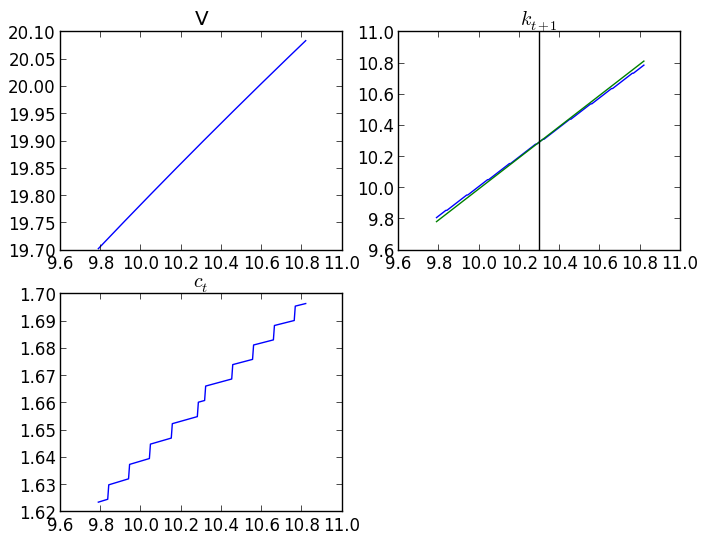

In [5]:
subplot(221)
plot(benchmark.k_grid, V_next)
title("V")
subplot(222)
plot(benchmark.k_grid, benchmark.k_grid[policy])
plot(benchmark.k_grid,benchmark.k_grid)
axvline(benchmark.k_stst, color="k")
title(L"$k_{t+1}$")
subplot(223)
plot(benchmark.k_grid, benchmark.kk2c(benchmark.k_grid,benchmark.k_grid[policy]));
title(L"$c_{t}$");

1.2.
--

In [6]:
function myVFIvect(m::GrowthModel; threshold=1e-4, max_iter=1000)
    
    V_old = m.V_stst*ones(m.k_grid_size)     #old continuation value function at grid points
    V_next = zeros(Float64, m.k_grid_size)   #new value function
    policy = zeros(Int64, m.k_grid_size)     #grid index of optimal choice
    
    F_mat = zeros(Float64,m.k_grid_size,m.k_grid_size)  #rows: choices, cols: states
    V_try = zeros(Float64,m.k_grid_size,m.k_grid_size) #rows: choices, cols: states
    
    t = 0
    err = 1.
    
    for (i,y) in enumerate(m.k_grid) #control    
        for (j,k) in enumerate(m.k_grid) #state
            F_mat[i,j] = m.kk2c(k,y) >= 0 ? m.F([k, y]) : -Inf
        end
    end
    
    while err>=threshold && t <= max_iter
        t += 1
        
        V_try = F_mat + m.β .* hcat([V_old for j=1:m.k_grid_size]...)
        
        for (i,k) in enumerate(m.k_grid) #state
            policy[i] = indmax(V_try[:,i])
            V_next[i] = V_try[policy[i],i]
        end
        
        err = maxabs(V_next .- V_old)
        V_old = copy(V_next)
    end
    
    if err>=threshold 
        warn("not converged!")
    end
    
    return (V_next, policy, t)
end

myVFIvect (generic function with 1 method)

In [7]:
@time (V_next, policy, t) = myVFIvect(benchmark);

  0.800078 seconds (1.29 M allocations: 258.780 MB, 9.86% gc time)


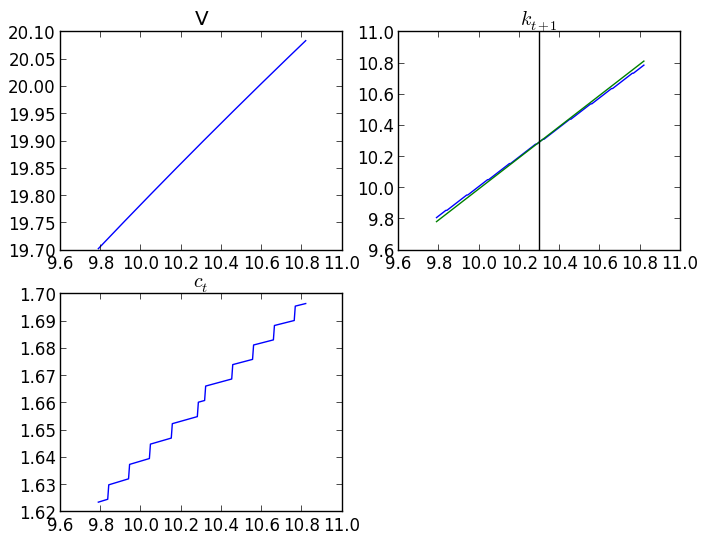

In [8]:
subplot(221)
plot(benchmark.k_grid, V_next)
title("V")
subplot(222)
plot(benchmark.k_grid, benchmark.k_grid[policy])
plot(benchmark.k_grid,benchmark.k_grid)
axvline(benchmark.k_stst, color="k")
title(L"$k_{t+1}$")
subplot(223)
plot(benchmark.k_grid, benchmark.kk2c(benchmark.k_grid,benchmark.k_grid[policy]));
title(L"$c_{t}$");

The vectorization yields a performance boost of factor 30!

1.3.
--
I give the code another makeover and use:

QuantEcon: Discrete Dynamic Programming 
--
The following is a rehash of my contribution to the "Discrete Dynamic Programming" lecture on QuantEcon, see: http://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.applications/blob/master/discrete_dp/discrete_dp_solutions_jl.ipynb

In [18]:
using QuantEcon

function destill_ddp(m::GrowthModel)
    C = m.kk2c(m.k_grid'',m.k_grid')                         #consumptions 
    coord = repmat(collect(1:m.k_grid_size),1,m.k_grid_size) #coordinates
    s_indices = coord[C.>0]                                  #feasible state coordinates
    a_indices = transpose(coord)[C.>0]                       #feasible action coordinates
    L = length(a_indices)

    Q = spzeros(L,m.k_grid_size)

    for i in 1:L
        Q[i,a_indices[i]] = 1
    end

    R = m.u(C[C.>0]) #reward

    return DiscreteDP(R, Q, m.β, s_indices, a_indices);
end

GrowthModel(0.5,1.5,k_grid_size=200);
ddp = destill_ddp(benchmark);

In [19]:
@time results = solve(ddp,VFI);

  0.071092 seconds (5.80 k allocations: 37.442 MB, 23.85% gc time)


Even faster!

In [20]:
function init_shooting(m::GrowthModel,k0::Real)
    
    return function shooting(guess,path=false)
        k=Array(Float64,200)
        k[1]=k0*m.k_stst; k[2]=guess

        for t in 3:200
            k[t] = -(((((1-m.δ)*k[t-2]+k[t-2]^m.α-k[t-1])^(-m.γ))/m.β/((1-m.δ)+m.α*k[t-1]^(m.α-1)))^(-1/m.γ) - 
            ((1-m.δ)*k[t-1] + k[t-1]^m.α))
        
            k[t] = maximum([eps(Float64),k[t]])
        end

        if path
            return k
        else
            return k[200]-m.k_stst
        end
    end
    
end

init_shooting (generic function with 1 method)

In [21]:
shooting = init_shooting(benchmark, 1/2)
k12_guess = fzero(shooting,5,6)
k12_path = shooting(k12_guess,true)
shooting = init_shooting(benchmark, 3/2)
k32_guess = fzero(shooting,14,16)
k32_path = shooting(k32_guess,true);

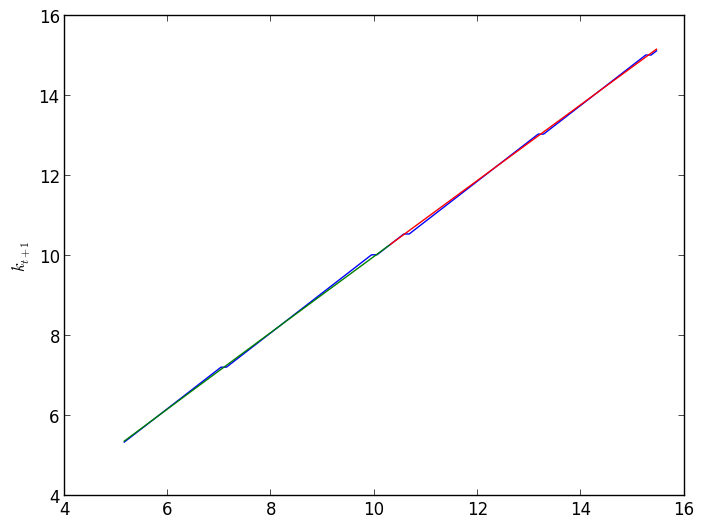

In [22]:
plot(benchmark.k_grid, benchmark.k_grid[results.sigma])
ylabel(L"$k_{t+1}$")
plot(k12_path[1:(length(k12_path)-1)], k12_path[2:end])
plot(k32_path[1:(length(k32_path)-1)], k32_path[2:end]);

The solutions are visually close, but still off a bit!

1.4.
--

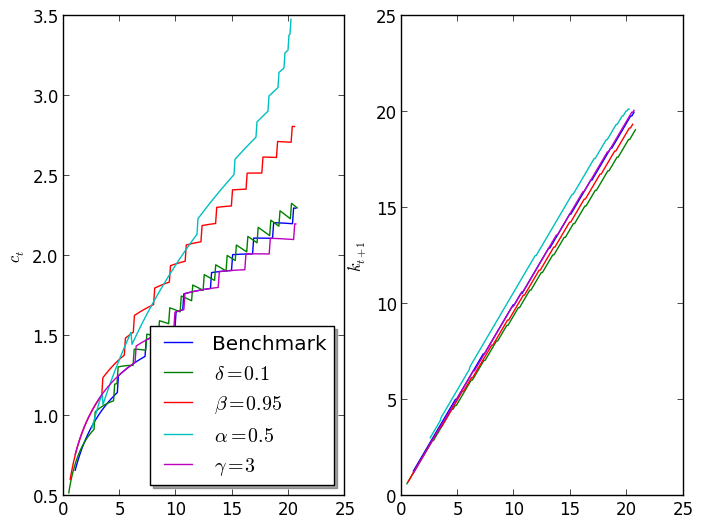

In [14]:
benchmark = GrowthModel(0.1,2,k_grid_size=200)
subplot(121)
plot(benchmark.k_grid, benchmark.kk2c(benchmark.k_grid, benchmark.k_grid[solve(destill_ddp(benchmark)).sigma]), label="Benchmark")
ylabel(L"$c_t$")

subplot(122)
plot(benchmark.k_grid, benchmark.k_grid[solve(destill_ddp(benchmark)).sigma])
ylabel(L"$k_{t+1}$")

model = GrowthModel(0.1,4.5,k_grid_size=200, δ=0.1)
subplot(121)
plot(model.k_grid, model.kk2c(model.k_grid, model.k_grid[solve(destill_ddp(model)).sigma]),label=L"$\delta=0.1$")
subplot(122)
plot(model.k_grid, model.k_grid[solve(destill_ddp(model)).sigma])

model = GrowthModel(0.1,3.5,k_grid_size=200, β=0.95)
subplot(121)
plot(model.k_grid, model.kk2c(model.k_grid, model.k_grid[solve(destill_ddp(model)).sigma]),label=L"$\beta=0.95$")
subplot(122)
plot(model.k_grid, model.k_grid[solve(destill_ddp(model)).sigma])

model = GrowthModel(0.05,0.4,k_grid_size=200, α=0.5)
subplot(121)
plot(model.k_grid, model.kk2c(model.k_grid, model.k_grid[solve(destill_ddp(model)).sigma]),label=L"$\alpha=0.5$")
subplot(122)
plot(model.k_grid, model.k_grid[solve(destill_ddp(model)).sigma])

model = GrowthModel(0.1,2,k_grid_size=200, γ=3)
subplot(121)
plot(model.k_grid, model.kk2c(model.k_grid, model.k_grid[solve(destill_ddp(model)).sigma]),label=L"$\gamma=3$")
legend(loc="lower right", shadow=true);
subplot(122)
plot(model.k_grid, model.k_grid[solve(destill_ddp(model)).sigma]);

A higher depreciation makes investment less profitable, hence the lower $k_{t+1}$. When $\beta$ decreases, the agent becomes less patient and saves less. The increased $\alpha$ leads to higher productivity. The lower IES, $\gamma$, tilts the tradeoff more in favor of saving. The lower $\beta$ lets the algorithm converge faster, because the $\beta$ is the factor of contraction of the Bellman operator.

1.5.
--

In [15]:
using Interpolations

function myVFIinterp(m::GrowthModel; threshold=1e-4, max_iter=1000)
    
    V_old = m.V_stst*ones(m.k_grid_size)    #old continuation value function at grid points
    V_next = zeros(Float64, m.k_grid_size)   #new value function
    policy = zeros(Int64, m.k_grid_size)     #grid index of optimal choice
    
    c_grid = linspace(0, 5, m.k_grid_size)
    
    G = m.lom(m.k_grid'',c_grid')'           #rows: choices, cols: states
    F_mat = hcat([m.u(c_grid) for j=1:m.k_grid_size]...)
    F_mat[G.<m.k_stst*m.k_grid_min] = -Inf
    F_mat[G.>m.k_stst*m.k_grid_max] = -Inf
    
    V_try = zeros(Float64,m.k_grid_size,m.k_grid_size) #rows: choices, cols: states

    t = 0
    err = 1.
    
    while err>=threshold && t <= max_iter
        t += 1
        Aw = scale(interpolate(V_old, BSpline(Linear()), OnGrid()), m.k_grid)
        
        V_try = F_mat + m.β .* reshape(map(x->Aw[x], G[:]),m.k_grid_size,m.k_grid_size)
        
        for (i,k) in enumerate(m.k_grid) #state
            policy[i] = indmax(V_try[:,i])
            V_next[i] = V_try[policy[i],i]
        end

        err = maxabs(V_next .- V_old)
        V_old = copy(V_next)
    end
    
    if err>=threshold 
        warn("not converged!")
    end
    
    return (V_next, policy, t, c_grid)
end

myVFIinterp (generic function with 1 method)

In [16]:
benchmark=GrowthModel(0.5,1.5,k_grid_size=100);
@time (V_next, policy, t, c_grid) = myVFIinterp(benchmark);
t

  1.262113 seconds (6.39 M allocations: 227.157 MB, 4.47% gc time)


288

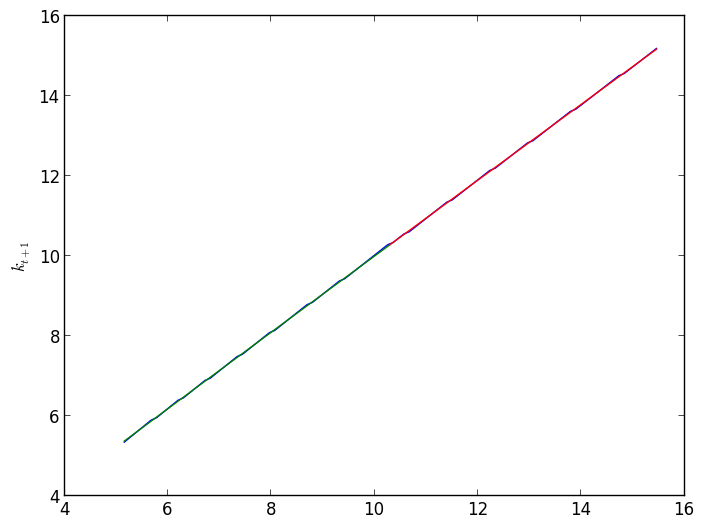

In [23]:
plot(benchmark.k_grid, benchmark.lom(benchmark.k_grid,c_grid[policy]))
ylabel(L"$k_{t+1}$")
plot(k12_path[1:(length(k12_path)-1)], k12_path[2:end])
plot(k32_path[1:(length(k32_path)-1)], k32_path[2:end]);

100 grid points give results that are very close to the shooting algorithm. The same plot in 1.3. using 200 grid points and discrete dynamic programming looks much more jagged, though.

1.4.
--